In [3]:
import earthaccess
auth = earthaccess.login(strategy="interactive", persist=True)

Authentication with Earthdata Login failed with:
{"error":"invalid_credentials","error_description":"Invalid user credentials"}


In [5]:
import numpy
from pathlib  import Path
import inspect

from matplotlib import pyplot as plt
import numpy as np
from copy import copy

import rioxarray
from pystac_client import Client
from shapely.geometry import Point

In [185]:
hls_lon, hls_lat = -122.189869, 46.211201
center_point = Point(hls_lon, hls_lat)
date = "2024-03-01/2024-05-31"

In [186]:
# connect to the STAC endpoint
cmr_api_url = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
client = Client.open(cmr_api_url)

In [187]:
search = client.search(
    collections=["HLSL30.v2.0"],
    intersects=center_point,
    datetime= date
) 
# uncomment below to see gory details
# help(search)

In [188]:
items = search.item_collection()
for index, the_scene in enumerate(items):
    print(f"\n\n{index=}\nproperties: {the_scene.properties}")



index=0
properties: {'datetime': '2024-03-19T18:55:48.197Z', 'eo:cloud_cover': 4, 'start_datetime': '2024-03-19T18:55:48.197Z', 'end_datetime': '2024-03-19T18:56:12.075Z'}


index=1
properties: {'datetime': '2024-04-04T18:56:03.110Z', 'eo:cloud_cover': 100, 'start_datetime': '2024-04-04T18:56:03.110Z', 'end_datetime': '2024-04-04T18:56:03.110Z'}


index=2
properties: {'datetime': '2024-04-12T18:55:13.070Z', 'eo:cloud_cover': 60, 'start_datetime': '2024-04-12T18:55:13.070Z', 'end_datetime': '2024-04-12T18:55:36.944Z'}


index=3
properties: {'datetime': '2024-04-20T18:55:23.635Z', 'eo:cloud_cover': 25, 'start_datetime': '2024-04-20T18:55:23.635Z', 'end_datetime': '2024-04-20T18:55:47.522Z'}


index=4
properties: {'datetime': '2024-04-28T18:55:02.676Z', 'eo:cloud_cover': 99, 'start_datetime': '2024-04-28T18:55:02.676Z', 'end_datetime': '2024-04-28T18:55:26.558Z'}


index=5
properties: {'datetime': '2024-05-06T18:55:15.635Z', 'eo:cloud_cover': 93, 'start_datetime': '2024-05-06T18:55:15.6

In [189]:
hls_scene = items[0]
hls_scene.assets

{'browse': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.jpg>,
 'thumbnail_0': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.jpg>,
 'thumbnail_1': <Asset href=s3://lp-prod-public/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.jpg>,
 'B11': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.B11.tif>,
 'B03': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.B03.tif>,
 'B10': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.B10.tif>,
 'S

In [190]:
hls_browse = rioxarray.open_rasterio(hls_scene.assets['browse'].href)

/Users/andrewbarnett/miniconda3/envs/a448/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


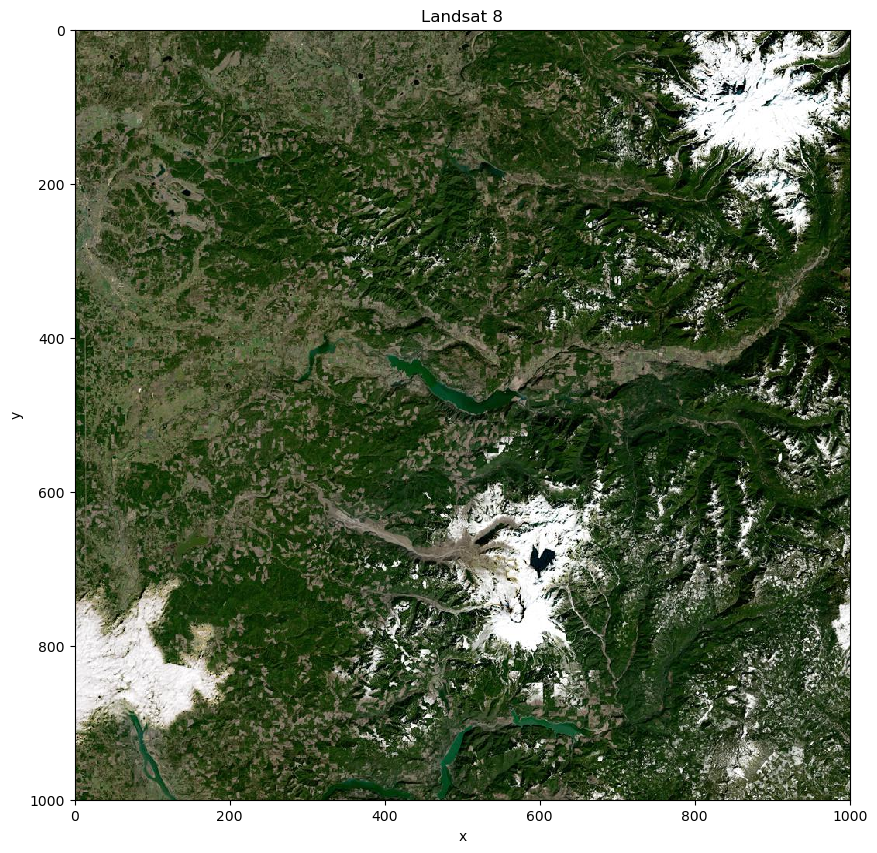

In [191]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
hls_browse.plot.imshow(ax=ax, origin = 'upper')
ax.set_title('Landsat 8');

In [192]:
band_name="B05"
hls_scene.assets[band_name].href

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.B05.tif'

In [193]:
import os
os.environ["GDAL_HTTP_COOKIEFILE"] = "./cookies.txt"
os.environ["GDAL_HTTP_COOKIEJAR"] = "./cookies.txt"

In [194]:
data_dir = Path().home() / 'repos/a448/data'
band_number = 5
data_dir.mkdir(exist_ok=True, parents=True)
disk_file = data_dir / f"spr2024_hls_landsat8_{band_number}.tif"
has_file = disk_file.exists()

from_disk = False
if from_disk:
    if not has_file:
        raise IOError(f"can't find {disk_file}, rerun with from_disk=False and writeit=True") 
    hls_band5 = rioxarray.open_rasterio(disk_file,masked=True)
else:
    # go to NASA
    hls_band5 = rioxarray.open_rasterio(hls_scene.assets[band_name].href,masked=True)

In [195]:
hls_raster = hls_band5.squeeze()
hls_raster = hls_raster*hls_band5.scale_factor
hls_raster.attrs, hls_raster.indexes

({},
 Indexes:
     x        Index([499995.0, 500025.0, 500055.0, 500085.0, 500115.0, 500145.0, 500175.0,
        500205.0, 500235.0, 500265.0,
        ...
        609495.0, 609525.0, 609555.0, 609585.0, 609615.0, 609645.0, 609675.0,
        609705.0, 609735.0, 609765.0],
       dtype='float64', name='x', length=3660)
     y        Index([5200005.0, 5199975.0, 5199945.0, 5199915.0, 5199885.0, 5199855.0,
        5199825.0, 5199795.0, 5199765.0, 5199735.0,
        ...
        5090505.0, 5090475.0, 5090445.0, 5090415.0, 5090385.0, 5090355.0,
        5090325.0, 5090295.0, 5090265.0, 5090235.0],
       dtype='float64', name='y', length=3660))

In [196]:
hls_raster.attrs = hls_band5.attrs
hls_raster.x[0]

<xarray.DataArray 'x' ()> Size: 8B
array(499995.)
Coordinates:
    band         int64 8B 1
    x            float64 8B 5e+05
    spatial_ref  int64 8B 0

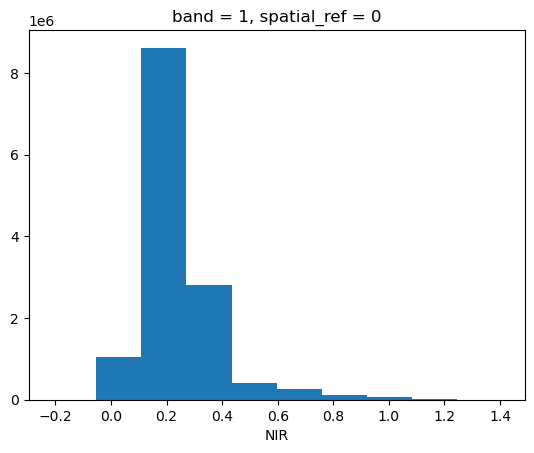

In [197]:
hls_raster.plot.hist();

In [198]:
writeit=True
if writeit:
    hls_band5.rio.to_raster(disk_file)
    #check if write worked
    hls_band5 = rioxarray.open_rasterio(disk_file,masked=True)
    print(f"checking read, here is the crs: {hls_band5.rio.crs}")

checking read, here is the crs: EPSG:32610


In [199]:
band_name="B04"
hls_scene.assets[band_name].href

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2024079T185548.v2.0/HLS.L30.T10TES.2024079T185548.v2.0.B04.tif'

In [200]:
data_dir = Path().home() / 'repos/a448/data'
band_number = 4
data_dir.mkdir(exist_ok=True, parents=True)
disk_file = data_dir / f"spr2024_hls_landsat8_{band_number}.tif"
has_file = disk_file.exists()

from_disk = False
if from_disk:
    if not has_file:
        raise IOError(f"can't find {disk_file}, rerun with from_disk=False and writeit=True") 
    hls_band4 = rioxarray.open_rasterio(disk_file,masked=True)
else:
    # go to NASA
    hls_band4 = rioxarray.open_rasterio(hls_scene.assets[band_name].href,masked=True)

In [201]:
hls_raster = hls_band4.squeeze()
hls_raster = hls_raster*hls_band4.scale_factor
hls_raster.attrs, hls_raster.indexes

({},
 Indexes:
     x        Index([499995.0, 500025.0, 500055.0, 500085.0, 500115.0, 500145.0, 500175.0,
        500205.0, 500235.0, 500265.0,
        ...
        609495.0, 609525.0, 609555.0, 609585.0, 609615.0, 609645.0, 609675.0,
        609705.0, 609735.0, 609765.0],
       dtype='float64', name='x', length=3660)
     y        Index([5200005.0, 5199975.0, 5199945.0, 5199915.0, 5199885.0, 5199855.0,
        5199825.0, 5199795.0, 5199765.0, 5199735.0,
        ...
        5090505.0, 5090475.0, 5090445.0, 5090415.0, 5090385.0, 5090355.0,
        5090325.0, 5090295.0, 5090265.0, 5090235.0],
       dtype='float64', name='y', length=3660))

In [202]:
hls_raster.attrs = hls_band4.attrs
hls_raster.x[0]

<xarray.DataArray 'x' ()> Size: 8B
array(499995.)
Coordinates:
    band         int64 8B 1
    x            float64 8B 5e+05
    spatial_ref  int64 8B 0

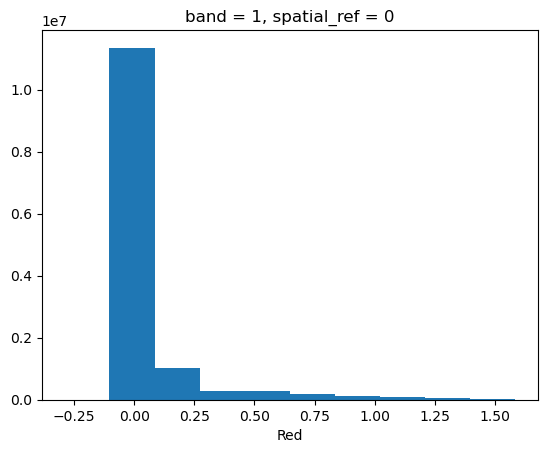

In [203]:
hls_raster.plot.hist();

In [204]:
writeit=True
if writeit:
    hls_band4.rio.to_raster(disk_file)
    #check if write worked
    hls_band4 = rioxarray.open_rasterio(disk_file,masked=True)
    print(f"checking read, here is the crs: {hls_band4.rio.crs}")

checking read, here is the crs: EPSG:32610
